# **Sentiment Classification of Customer Reviews for Product Insights**

The goal of this project is to classify customer reviews as positive or negative using TF-IDF and Logistic Regression, as well as look at the top recurring keywords for both in order to understand specifically which experiences drive reviews, and therefore to drive CX (customer experience) strategy development.

>**Dataset**: Yelp Polarity Reviews
>
>**References**: Zhang, X., Zhao, J., & LeCun, Y. (2015). Character-level Convolutional Networks for Text Classification. In Advances in Neural Information Processing Systems (pp. 649–657).

## **Step 1: Dataset Load and Preprocessing**

In [5]:
!pip install datasets
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from wordcloud import WordCloud
import shap
import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from datasets import load_dataset
import re

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system ==

In [6]:
dataset = load_dataset("yelp_polarity", split="train[:20%]") # 80:20 test train split
dataset = dataset.shuffle(seed=42)  # Shuffle for randomness

# Convert to pandas DataFrame
df = pd.DataFrame(dataset)
df.head()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.93k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/256M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/560000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/38000 [00:00<?, ? examples/s]

,text,label
0,Something about The Old Spaghetti Factory that...,0
1,First time at Rio - check in at 5 took 20 minu...,0
2,With our mouths still on fire from an amazing ...,1
3,I really love Malee's and the food is always g...,1
4,Awesome place!!! a nail junkies version of hea...,1


In [7]:
# Modifying text for consistency
def clean_text(text):
    text = text.lower() # convert all text to lowercase
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text) # remove punctuation
    text = re.sub(r"\s+", " ", text).strip() # remove extra whitespace
    return text

df['clean_text'] = df['text'].apply(clean_text)
df[['text', 'clean_text']].head()


,text,clean_text
0,Something about The Old Spaghetti Factory that...,something about the old spaghetti factory that...
1,First time at Rio - check in at 5 took 20 minu...,first time at rio check in at 5 took 20 minute...
2,With our mouths still on fire from an amazing ...,with our mouths still on fire from an amazing ...
3,I really love Malee's and the food is always g...,i really love malees and the food is always go...
4,Awesome place!!! a nail junkies version of hea...,awesome place a nail junkies version of heaven...


# **Step 2: Exploratory Data Analysis: Visualising the Overall Distribution of Positive and Negative Reviews**

<ipython-input-8-8a49dbbf8d66>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='label', data=df, palette=['#FF6B6B', '#4ECDC4'])
<ipython-input-8-8a49dbbf8d66>:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Negative', 'Positive'], fontsize=12)


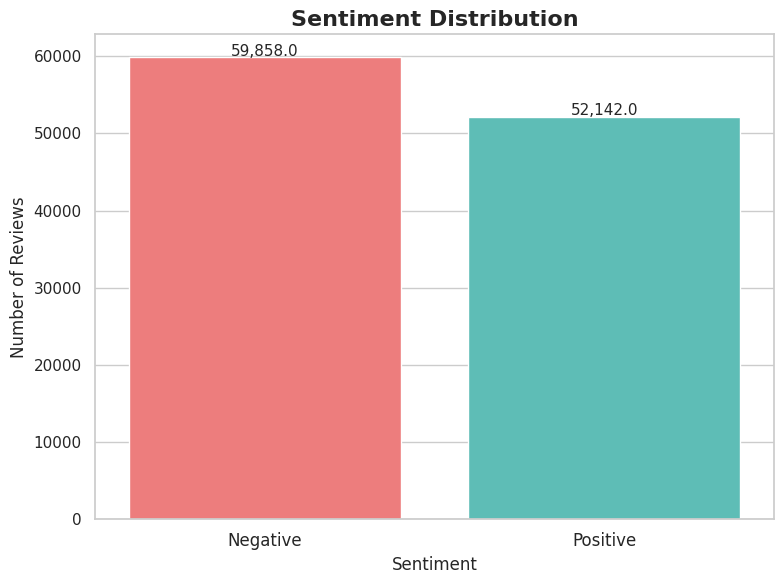

In [8]:
sns.set(style="whitegrid")

# Create count plot
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='label', data=df, palette=['#FF6B6B', '#4ECDC4'])

# Labels
ax.set_xticklabels(['Negative', 'Positive'], fontsize=12)
ax.set_title("Sentiment Distribution", fontsize=16, fontweight='bold')
ax.set_xlabel("Sentiment", fontsize=12)
ax.set_ylabel("Number of Reviews", fontsize=12)

# Labels for bars
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 200, f'{height:,}',
            ha="center", fontsize=11)

plt.tight_layout()
plt.show()

# **Step 3: Model Development and Evaluation Metrics**

TF-IDF (Term Frequency–Inverse Document Frequency) is an interpretable statistic indicating the relative significance of words in predicting sentiment. This ensures that words in the reviews are assigned weight in relation to their relative importance among all the words that occur in the reviews.

---



In [9]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(df["text"], df["label"], test_size=0.2, random_state=42)

# TF-IDF + Logistic Regression
vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
model = LogisticRegression(max_iter=1000)
pipeline = make_pipeline(vectorizer, model)
pipeline.fit(X_train, y_train)

# Get predictions
y_pred = pipeline.predict(X_test)

# Get precision, recall, and F1-score
print(classification_report(y_test, y_pred, target_names=["Negative", "Positive"]))

              precision    recall  f1-score   support

    Negative       0.92      0.92      0.92     11842
    Positive       0.91      0.90      0.91     10558

    accuracy                           0.91     22400
   macro avg       0.91      0.91      0.91     22400
weighted avg       0.91      0.91      0.91     22400



## Example: Running the Model with A Sample Review

You can replace the text in the predict_sentiment function with a review entered by you to illustrate how the model classifies reviews as positive or negative.

In [10]:
def predict_sentiment(text):
    cleaned = clean_text(text)
    vectorized = vectorizer.transform([cleaned])
    prediction = model.predict(vectorized)[0]
    return "Positive" if prediction == 1 else "Negative"

predict_sentiment("We were left waiting for so long.")

'Negative'

# **Insights: Discovering Trends in Reviews**

## Most Frequently Occuring Positive and Negative Words

These are the top keywords that appear to drive positive and negative sentiment. These can heavily inform business strategy.


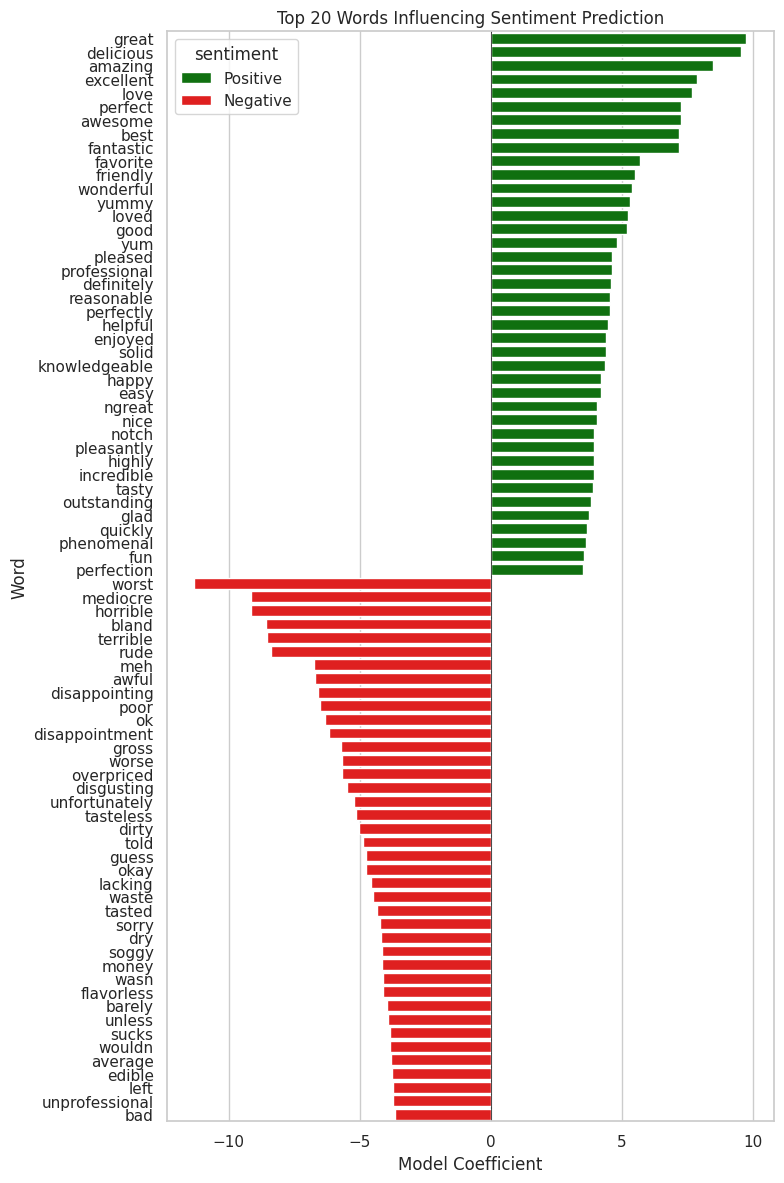

In [21]:
feature_names = vectorizer.get_feature_names_out()
coefficients = model.coef_[0]

coef_df = pd.DataFrame({
    'word': feature_names,
    'coefficient': coefficients
})

top_pos = coef_df.sort_values(by='coefficient', ascending=False).head(40)
top_neg = coef_df.sort_values(by='coefficient').head(40)

top_words = pd.concat([top_pos, top_neg])
top_words['sentiment'] = ['Positive'] * 40 + ['Negative'] * 40

plt.figure(figsize=(8, 12))
sns.barplot(data=top_words, x='coefficient', y='word', hue='sentiment',
            palette={'Positive': 'green', 'Negative': 'red'})
plt.axvline(0, color='black', linewidth=0.5)
plt.title("Top 20 Words Influencing Sentiment Prediction")
plt.xlabel("Model Coefficient")
plt.ylabel("Word")
plt.tight_layout()
plt.show()

# **SHAP Values**

SHAP values indicate the influence that a keyword has on the model's outcome.
>**Positive SHAP Value**: The feature pushes the model’s prediction towards the positive class.
>
>**Negative SHAP Value**: The feature pushes the model’s prediction towards the negative class.

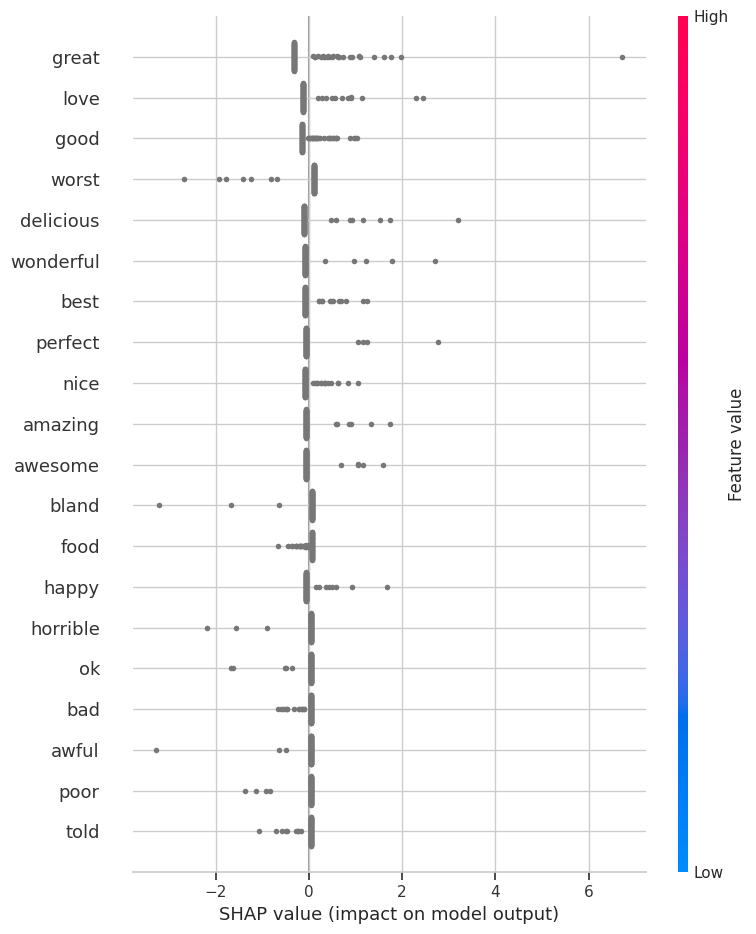

In [22]:
X_test_tfidf = vectorizer.transform(X_test[:100])
explainer = shap.Explainer(model, X_test_tfidf)
shap_values = explainer(X_test_tfidf)

shap.summary_plot(shap_values, X_test_tfidf, feature_names=vectorizer.get_feature_names_out(), show=True)
coefficients = model.coef_[0]
top_idx = np.argsort(np.abs(coefficients))[-40:]
top_words = [(vectorizer.get_feature_names_out()[i], coefficients[i]) for i in reversed(top_idx)]

## Top words influencing predictions

In [23]:
for word, coef in top_words:
    print(f"{word}: {coef:.3f} ({'Positive' if coef > 0 else 'Negative'})")

worst: -11.301 (Negative)
great: 9.765 (Positive)
delicious: 9.569 (Positive)
mediocre: -9.139 (Negative)
horrible: -9.137 (Negative)
bland: -8.563 (Negative)
terrible: -8.518 (Negative)
amazing: 8.478 (Positive)
rude: -8.386 (Negative)
excellent: 7.864 (Positive)
love: 7.693 (Positive)
perfect: 7.258 (Positive)
awesome: 7.256 (Positive)
best: 7.182 (Positive)
fantastic: 7.178 (Positive)
meh: -6.753 (Negative)
awful: -6.694 (Negative)
disappointing: -6.589 (Negative)
poor: -6.502 (Negative)
ok: -6.318 (Negative)
disappointment: -6.156 (Negative)
gross: -5.723 (Negative)
favorite: 5.714 (Positive)
worse: -5.687 (Negative)
overpriced: -5.683 (Negative)
friendly: 5.522 (Positive)
disgusting: -5.487 (Negative)
wonderful: 5.403 (Positive)
yummy: 5.308 (Positive)
loved: 5.230 (Positive)
unfortunately: -5.209 (Negative)
good: 5.206 (Positive)
tasteless: -5.146 (Negative)
dirty: -5.031 (Negative)
told: -4.861 (Negative)
yum: 4.842 (Positive)
guess: -4.764 (Negative)
okay: -4.743 (Negative)
ple

#**Key Results and Recommendations**

**Strategic Recommendations**

* **Improve Consistency in Service Quality**
The presence of words like “rude” and “unfortunately” points to inconsistent or disappointing service interactions. Implement customer service training and real-time feedback mechanisms to ensure consistently positive experiences.

* **Prioritize Food Quality and Taste**:
Words like “bland,” “tasteless,” and “gross” indicate dissatisfaction with food preparation. Standardize food preparation procedures and monitor kitchen performance closely to maintain taste and quality.

* **Leverage Positive Themes in Marketing**:
Highlight top positive sentiment drivers such as “delicious,” “awesome,” “friendly,” and “fantastic” in branding and promotions. Reinforcing these strengths can attract new customers and build loyalty.

* **Monitor and Respond to Negative Trends Early**:
Use sentiment analysis tools to flag reviews containing highly negative keywords (e.g., “awful,” “worst,” “disgusting”) for immediate escalation. This allows the team to respond quickly and mitigate reputational risk.